Found 150 frames. First: plane_00000.bin, Last: plane_00149.bin
plane_00000.bin: min=0, max=112.5, mean=0.0228882
plane_00075.bin: min=0, max=719.197, mean=1.7395
plane_00149.bin: min=0, max=838.354, mean=3.43323
Using global color limits: vmin=1e-12, vmax=112.5


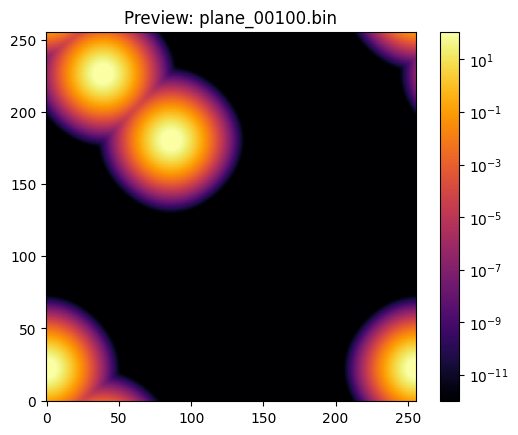

Saved GIF → evolution.gif


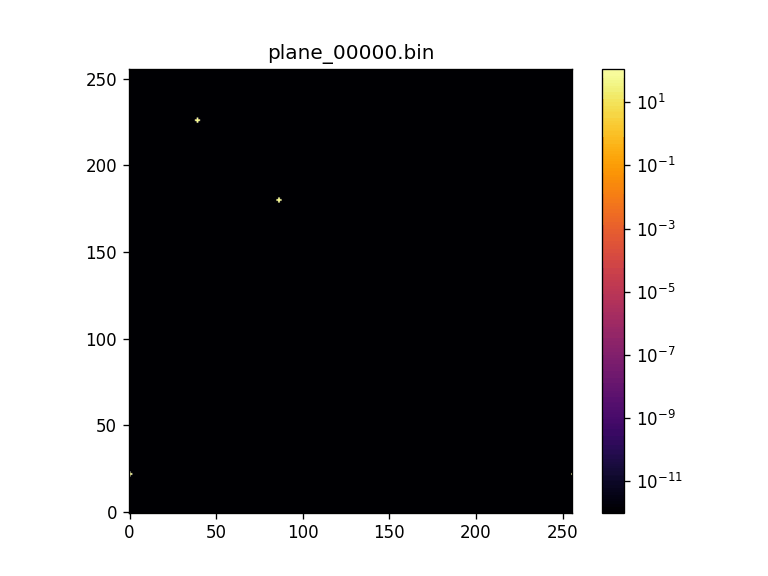

In [14]:
# --- Parameters (edit these) ---
from pathlib import Path

DATA_DIR = Path('.')         # folder containing your .bin files
PATTERN = 'plane_*.bin'      # file pattern
SX, SY = 256, 256            # grid size used in the simulation

# Visualization options
USE_LOG = True              # set True if your data are non-negative and very peaked
ANIM_FPS = 12                # frames per second for the GIF
OUT_GIF = 'evolution.gif'    # output filename

# --- Imports (matplotlib only, no seaborn) ---
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.colors import LogNorm
from IPython.display import Image, display

# --- Discover files ---
files = sorted(Path(DATA_DIR).glob(PATTERN))
if not files:
    raise FileNotFoundError(f'No files found in {DATA_DIR} matching {PATTERN!r}')
print(f'Found {len(files)} frames. First: {files[0].name}, Last: {files[-1].name}')

def load_frame_by_index(k: int) -> np.ndarray:
    """Load frame k (0-based) and reshape to (SY, SX) as float32."""
    f = files[k]
    arr = np.fromfile(f, dtype=np.float32)
    expected = SX * SY
    if arr.size != expected:
        raise ValueError(f'File {f} has {arr.size} floats; expected {expected} = SX*SY. '
                         f'Check SX,SY or the file pattern.')
    return arr.reshape(SY, SX)

# --- Quick sanity on a few frames ---
for idx in (0, len(files)//2, len(files)-1):
    a = np.fromfile(files[idx], np.float32)
    print(f'{files[idx].name}: min={a.min():.6g}, max={a.max():.6g}, mean={a.mean():.6g}')


arr0 = load_frame_by_index(0)
if USE_LOG:
    arr0 = np.maximum(arr0, 1e-12)
vmin, vmax = float(arr0.min()), float(arr0.max())

# ensure a tiny positive span to avoid flat colormap
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmax <= vmin:
    vmax = (1e-9 if vmin == 0.0 else vmin + abs(vmin)*1e-6)

print(f'Using global color limits: vmin={vmin:.6g}, vmax={vmax:.6g}')

# --- Preview a single frame ---
k_preview = min(100, len(files)-1)  # change if you like
arr = load_frame_by_index(k_preview)
if USE_LOG:
    arr = np.maximum(arr, 1e-12)

plt.figure()
norm = LogNorm(vmin=max(vmin, 1e-12), vmax=vmax) if USE_LOG else None
im = plt.imshow(arr, origin='lower', aspect='equal', norm=norm, cmap='inferno')
im.set_clim(vmin, vmax)
plt.colorbar()
plt.title(f'Preview: {files[k_preview].name}')
plt.show()

# --- Build & save the GIF animation ---
first = load_frame_by_index(0)
if USE_LOG:
    first = np.maximum(first, 1e-12)

fig = plt.figure()
norm = LogNorm(vmin=max(vmin, 1e-12), vmax=vmax) if USE_LOG else None
im = plt.imshow(first, origin='lower', aspect='equal', norm=norm, cmap='inferno')
im.set_clim(vmin, vmax)
plt.colorbar()
plt.title(files[0].name)

def update(frame_idx):
    arr = load_frame_by_index(frame_idx)
    if USE_LOG:
        arr = np.maximum(arr, 1e-12)
    im.set_array(arr)
    plt.title(files[frame_idx].name)
    return [im]

ani = anim.FuncAnimation(fig, update, frames=len(files), interval=1000/ANIM_FPS, blit=False)
ani.save(OUT_GIF, dpi=120, writer='pillow')
plt.close(fig)

print(f"Saved GIF → {OUT_GIF}")
display(Image(filename=OUT_GIF))
